<a href="https://colab.research.google.com/github/amanjain252002/Stock-Price-Prediction/blob/main/Deep_Learning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install the required libraries and utilities  to be able to reproduce this research paper.
# Uncomment the line below and run the cell. Best to create a virtual environment before completing this step.
# The virtual enviroment is based on python=3.8.6, pip=24.3.1
#!pip install pandas numpy matplotlib jupyter tqdm pydot
#!pip install scikit-learn
# Tensorflow-metal is optional, only install if on Apple Macbook
#!pip install tensorflow tensorflow-metal
# Graphviz is required, for installation method check documentation at https://graphviz.gitlab.io/download/

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings('ignore')

In [3]:
AAPL = pd.read_csv("./Database/Pre_Processed_AAPL.csv")
AMZN = pd.read_csv("./Database/Pre_Processed_AMZN.csv")
GOOG = pd.read_csv("./Database/Pre_Processed_GOOG.csv")
MSFT = pd.read_csv("./Database/Pre_Processed_MSFT.csv")
TSLA = pd.read_csv("./Database/Pre_Processed_TSLA.csv")

### Data Preprocessing

In [4]:
def Dataset(Data, Date):

  Train_Data = Data['Adj. Close'][Data['Date'] < Date].to_numpy()
  Data_Train = []
  Data_Train_X = []
  Data_Train_Y = []
  for i in range(0, len(Train_Data), 5):
    try:
      Data_Train.append(Train_Data[i : i + 5])
    except:
      pass

  if len(Data_Train[-1]) < 5:
    Data_Train.pop(-1)
  
  Data_Train_X = Data_Train[0 : -1]
  Data_Train_X = np.array(Data_Train_X)
  Data_Train_X = Data_Train_X.reshape((-1, 5, 1))
  Data_Train_Y = Data_Train[1 : len(Data_Train)]
  Data_Train_Y = np.array(Data_Train_Y)
  Data_Train_Y = Data_Train_Y.reshape((-1, 5, 1))


  Test_Data = Data['Adj. Close'][Data['Date'] >= Date].to_numpy()
  Data_Test = []
  Data_Test_X = []
  Data_Test_Y = []
  for i in range(0, len(Test_Data), 5):
    try:
      Data_Test.append(Test_Data[i : i + 5])
    except:
      pass

  if len(Data_Test[-1]) < 5:
    Data_Test.pop(-1)
  
  Data_Test_X = Data_Test[0 : -1]
  Data_Test_X = np.array(Data_Test_X)
  Data_Test_X = Data_Test_X.reshape((-1, 5, 1))
  Data_Test_Y = Data_Test[1 : len(Data_Test)]
  Data_Test_Y = np.array(Data_Test_Y)
  Data_Test_Y = Data_Test_Y.reshape((-1, 5, 1))

  return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y

### Model

In [5]:
def Model():
  model = tf.keras.models.Sequential([
                                      tf.keras.layers.LSTM(200, input_shape = (5, 1), activation = tf.nn.leaky_relu, return_sequences = True),
                                      tf.keras.layers.LSTM(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(200, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(100, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(50, activation = tf.nn.leaky_relu),
                                      tf.keras.layers.Dense(5, activation = tf.nn.leaky_relu)
                                      ])
  return model

In [6]:
model = Model()

2024-12-08 09:31:52.405426: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-08 09:31:52.405457: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-12-08 09:31:52.405463: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-12-08 09:31:52.405845: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-08 09:31:52.406240: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


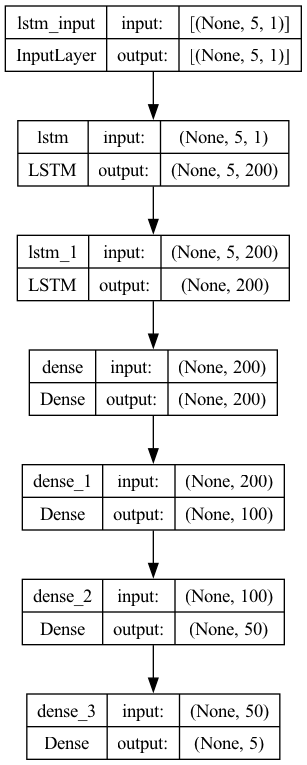

In [7]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 200)            161600    
                                                                 
 lstm_1 (LSTM)               (None, 200)               320800    
                                                                 
 dense (Dense)               (None, 200)               40200     
                                                                 
 dense_1 (Dense)             (None, 100)               20100     
                                                                 
 dense_2 (Dense)             (None, 50)                5050      
                                                                 
 dense_3 (Dense)             (None, 5)                 255       
                                                                 
Total params: 548005 (2.09 MB)
Trainable params: 548005 

### Custom Learning Rate

In [9]:
def scheduler(epoch):
  
  if epoch <= 150:
    lrate = (10 ** -5) * (epoch / 150) 
  elif epoch <= 400:
    initial_lrate = (10 ** -5)
    k = 0.01
    lrate = initial_lrate * math.exp(-k * (epoch - 150))
  else:
    lrate = (10 ** -6)
  
  return lrate

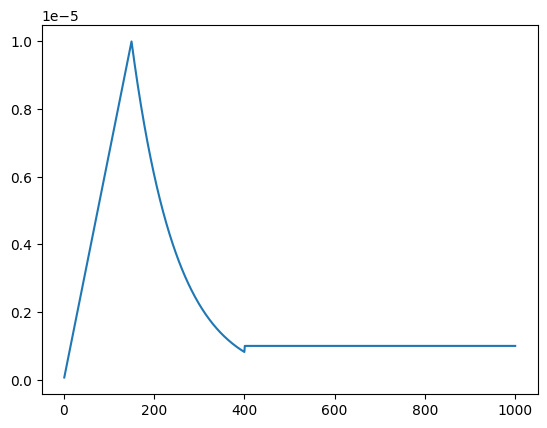

In [10]:
epochs = [i for i in range(1, 1001, 1)]
lrate = [scheduler(i) for i in range(1, 1001, 1)]
plt.plot(epochs, lrate)

In [11]:
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Apple

In [12]:
AAPL.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,27.85,27.86,26.84,27.33,24.86,212818400.0
1,2015-01-05,27.07,27.16,26.35,26.56,24.16,257142000.0
2,2015-01-06,26.64,26.86,26.16,26.57,24.16,263188400.0
3,2015-01-07,26.80,27.05,26.67,26.94,24.50,160423600.0
4,2015-01-08,27.31,28.04,27.17,27.97,25.44,237458000.0


In [13]:
AAPL.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [14]:
# Change Dtype of Date column
AAPL["Date"] = pd.to_datetime(AAPL["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [15]:
AAPL_Date = '2020-10-01'
AAPL_Train_X, AAPL_Train_Y, AAPL_Test_X, AAPL_Test_Y = Dataset(AAPL, AAPL_Date)

### Model Fitting

In [16]:
AAPL_Model = Model()

In [17]:
# Change the keras optimiser to legacy Adam since running on Apple MacBook Silicon to avoid slowdown
AAPL_Model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

# Change to this code if using other CPUs apart from Apple Silicon
#AAPL_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [18]:
AAPL_hist = AAPL_Model.fit(AAPL_Train_X, AAPL_Train_Y, epochs = 1000, validation_data = (AAPL_Test_X, AAPL_Test_Y), callbacks=[callback], verbose=0)

2024-12-08 09:31:54.020716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-08 09:31:54.994655: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [19]:
history_dict = AAPL_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

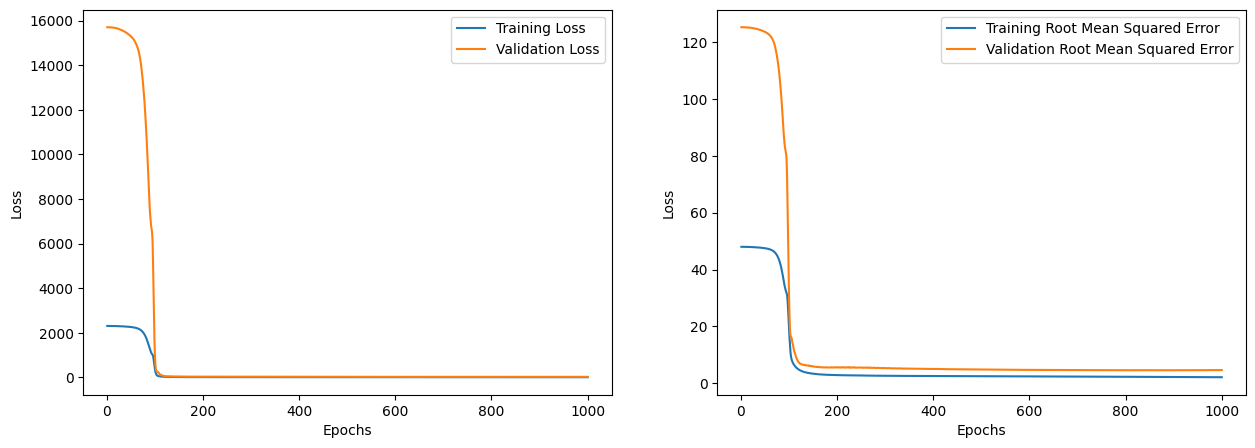

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = 'Training Loss')
ax1.plot(epochs, val_loss, label = 'Validation Loss')
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Apple

In [21]:
AAPL_prediction = AAPL_Model.predict(AAPL_Test_X)

1/1 [==============================] - 0s 183ms/step


2024-12-08 09:39:10.256293: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


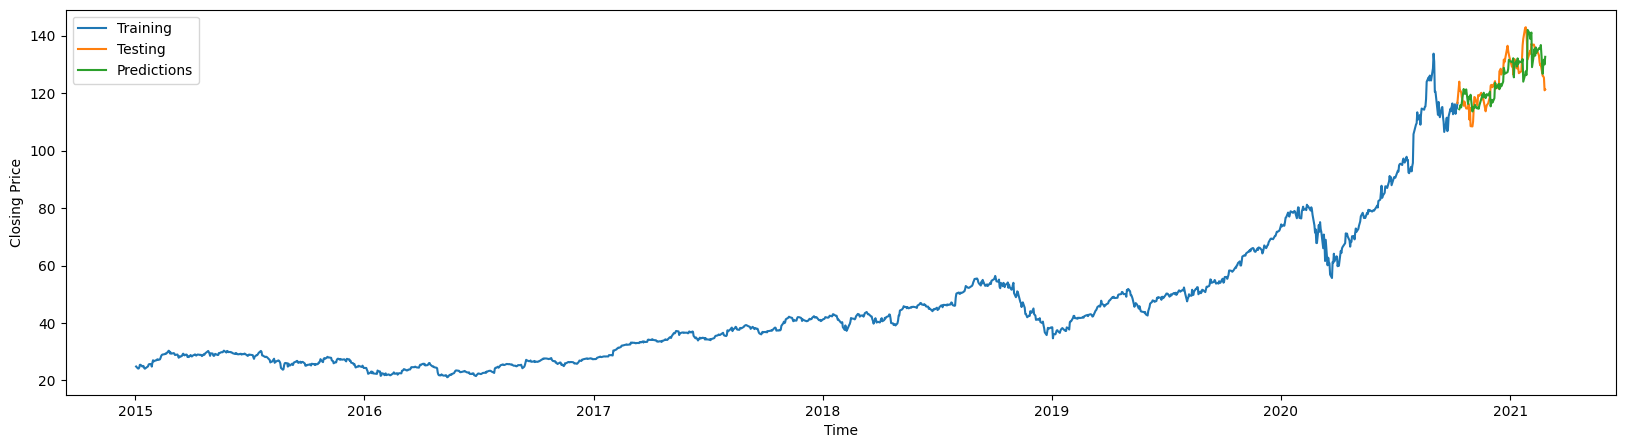

In [22]:
plt.figure(figsize=(20, 5))
plt.plot(AAPL['Date'][AAPL['Date'] < '2020-10-12'], AAPL['Adj. Close'][AAPL['Date'] < '2020-10-12'], label = 'Training')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-09'], AAPL['Adj. Close'][AAPL['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(AAPL['Date'][AAPL['Date'] >= '2020-10-12'], AAPL_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [23]:
rmse = math.sqrt(mean_squared_error(AAPL_Test_Y.reshape(-1, 5), AAPL_prediction))
mape = np.mean(np.abs(AAPL_prediction - AAPL_Test_Y.reshape(-1, 5))/np.abs(AAPL_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 4.6089121141192
MAPE: 0.027990725147531797


# Tesla

In [24]:
TSLA.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,44.57,44.65,42.65,43.86,43.86,23822000.0
1,2015-01-05,42.91,43.30,41.43,42.02,42.02,26842500.0
2,2015-01-06,42.01,42.84,40.84,42.26,42.26,31309500.0
3,2015-01-07,42.67,42.96,41.96,42.19,42.19,14842000.0
4,2015-01-08,42.56,42.76,42.00,42.12,42.12,17212500.0


In [25]:
TSLA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [26]:
# Change Dtype of Date column
TSLA["Date"] = pd.to_datetime(TSLA["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [27]:
TSLA_Date = '2020-10-01'
TSLA_Train_X, TSLA_Train_Y, TSLA_Test_X, TSLA_Test_Y = Dataset(TSLA, TSLA_Date)

### Model Fitting

In [28]:
TSLA_Model = Model()

In [29]:
# Change the keras optimiser to legacy Adam since running on Apple MacBook Silicon to avoid slowdown
TSLA_Model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

# Uncomment this code if using other CPUs apart from Apple Silicon and comment out the one above
#TSLA_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [30]:
TSLA_hist = TSLA_Model.fit(TSLA_Train_X, TSLA_Train_Y, epochs = 200, validation_data = (TSLA_Test_X, TSLA_Test_Y), callbacks=[callback], verbose=0)

2024-12-08 09:39:11.003288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-08 09:39:11.861049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [31]:
history_dict = TSLA_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

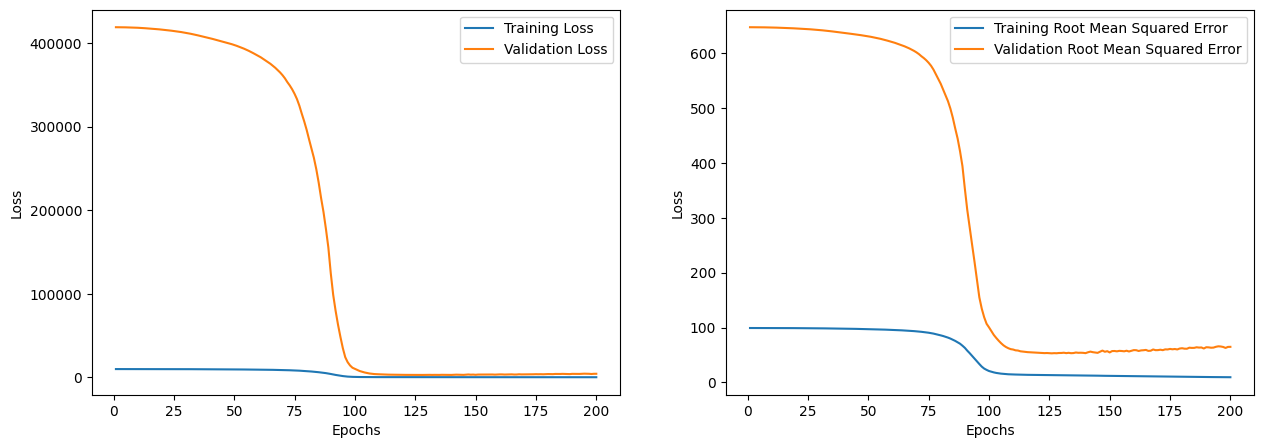

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Tesla

In [33]:
TSLA_prediction = TSLA_Model.predict(TSLA_Test_X)

1/1 [==============================] - 0s 177ms/step


2024-12-08 09:40:38.446969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


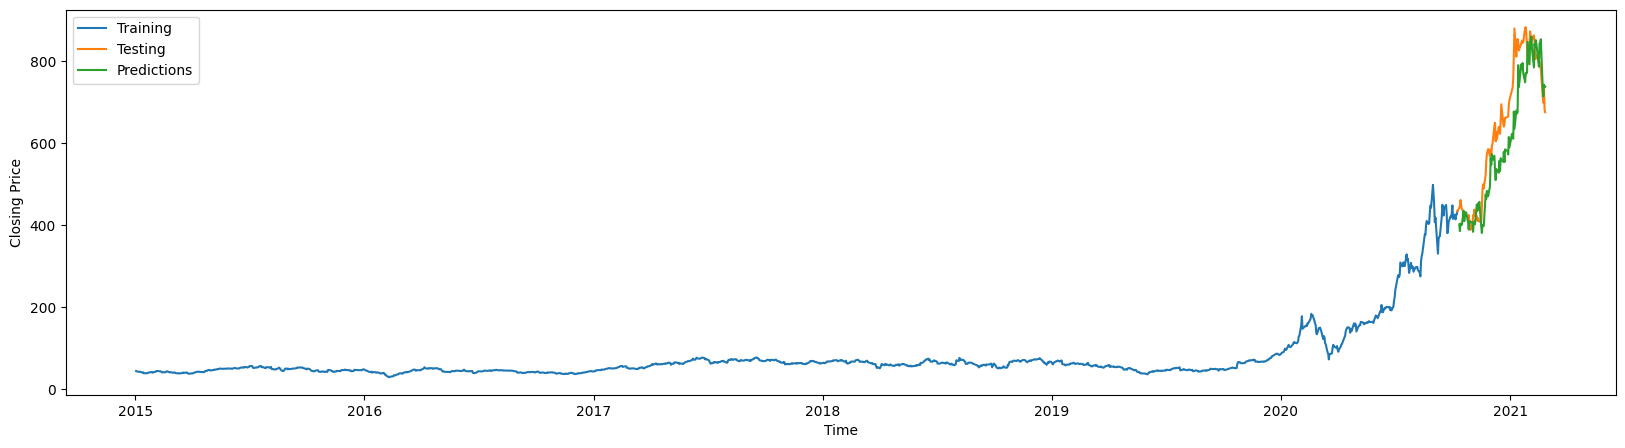

In [34]:
plt.figure(figsize=(20, 5))
plt.plot(TSLA['Date'][TSLA['Date'] < '2020-10-12'], TSLA['Adj. Close'][TSLA['Date'] < '2020-10-12'], label = 'Training')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-09'], TSLA['Adj. Close'][TSLA['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(TSLA['Date'][TSLA['Date'] >= '2020-10-12'], TSLA_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [35]:
rmse = math.sqrt(mean_squared_error(TSLA_Test_Y.reshape(-1, 5), TSLA_prediction))
mape = np.mean(np.abs(TSLA_prediction - TSLA_Test_Y.reshape(-1, 5))/np.abs(TSLA_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 64.89839254949158
MAPE: 0.07785572887690762


# Google

In [36]:
GOOG.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,527.56,529.82,522.67,523.37,523.37,1447563.0
1,2015-01-05,521.83,522.89,511.66,512.46,512.46,2059840.0
2,2015-01-06,513.59,514.76,499.68,500.59,500.59,2899940.0
3,2015-01-07,505.61,505.86,498.28,499.73,499.73,2065054.0
4,2015-01-08,496.63,502.10,489.66,501.30,501.30,3353582.0


In [37]:
GOOG.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [38]:
# Change Dtype of Date column
GOOG["Date"] = pd.to_datetime(GOOG["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [39]:
GOOG_Date = '2020-11-01'
GOOG_Train_X, GOOG_Train_Y, GOOG_Test_X, GOOG_Test_Y = Dataset(GOOG, GOOG_Date)

### Model Fitting

In [40]:
GOOG_Model = Model()

In [41]:
# Change the keras optimiser to legacy Adam since running on Apple MacBook Silicon to avoid slowdown
GOOG_Model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

# Uncomment this code if using other CPUs apart from Apple Silicon and comment out the one above
#GOOG_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [42]:
GOOG_hist = GOOG_Model.fit(GOOG_Train_X, GOOG_Train_Y, epochs = 1000, validation_data = (GOOG_Test_X, GOOG_Test_Y), callbacks = [callback], verbose=0)

2024-12-08 09:40:39.372688: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-08 09:40:40.769443: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [43]:
history_dict = GOOG_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

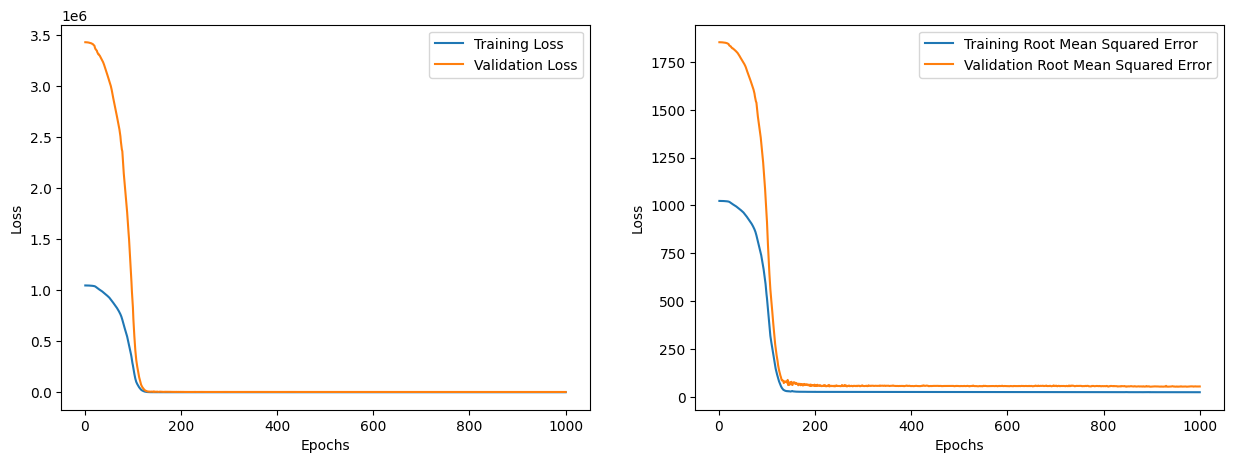

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Google

In [45]:
GOOG_prediction = GOOG_Model.predict(GOOG_Test_X)

1/1 [==============================] - 0s 200ms/step


2024-12-08 09:53:50.693172: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


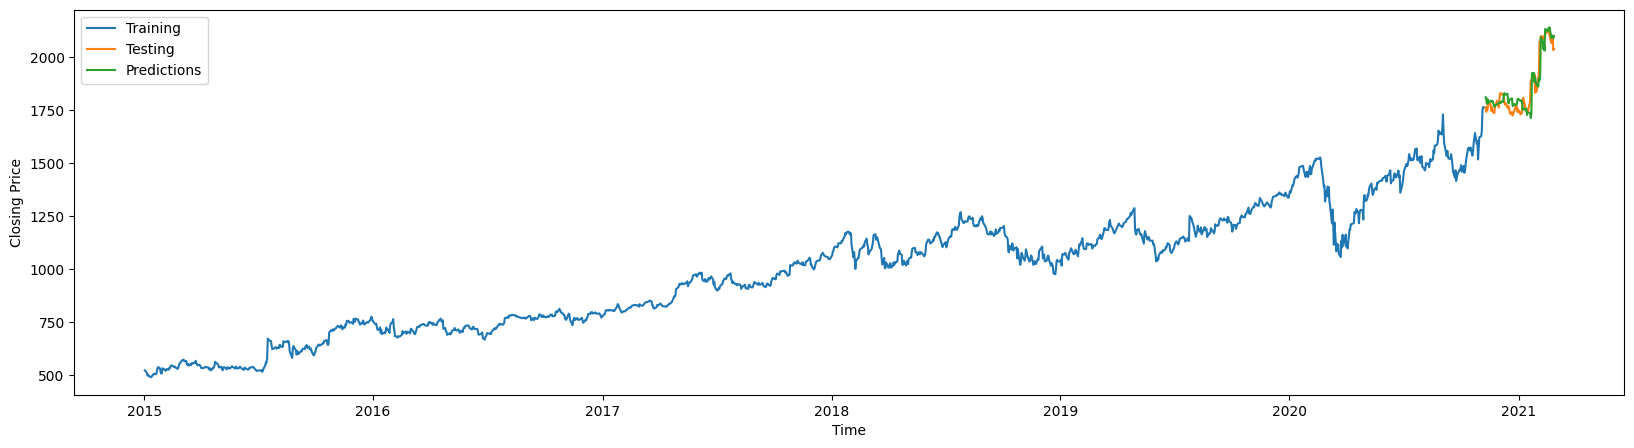

In [46]:
plt.figure(figsize=(20, 5))
plt.plot(GOOG['Date'][GOOG['Date'] < '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] < '2020-11-07'], label = 'Training')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG['Adj. Close'][GOOG['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(GOOG['Date'][GOOG['Date'] >= '2020-11-07'], GOOG_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [47]:
rmse = math.sqrt(mean_squared_error(GOOG_Test_Y.reshape(-1, 5), GOOG_prediction))
mape = np.mean(np.abs(GOOG_prediction - GOOG_Test_Y.reshape(-1, 5))/np.abs(GOOG_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 54.00720013285739
MAPE: 0.021530931738439372


# Microsoft

In [48]:
MSFT.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,46.66,47.42,46.54,46.76,41.44,27913900.0
1,2015-01-05,46.37,46.73,46.25,46.33,41.06,39673900.0
2,2015-01-06,46.38,46.75,45.54,45.65,40.46,36447900.0
3,2015-01-07,45.98,46.46,45.49,46.23,40.97,29114100.0
4,2015-01-08,46.75,47.75,46.72,47.59,42.18,29645200.0


In [49]:
MSFT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [50]:
# Change Dtype of Date column
MSFT["Date"] = pd.to_datetime(MSFT["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-09-30

    Testing Period:  2020-10-01 - 2021-02-26

In [51]:
MSFT_Date = '2020-10-01'
MSFT_Train_X, MSFT_Train_Y, MSFT_Test_X, MSFT_Test_Y = Dataset(MSFT, MSFT_Date)

### Model Fitting

In [52]:
MSFT_Model = Model()

In [53]:
# Change the keras optimiser to legacy Adam since running on Apple MacBook Silicon to avoid slowdown
MSFT_Model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

# Uncomment this code if using other CPUs apart from Apple Silicon and comment out the one above
#MSFT_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [54]:
MSFT_hist = MSFT_Model.fit(MSFT_Train_X, MSFT_Train_Y, epochs = 1000, validation_data = (MSFT_Test_X, MSFT_Test_Y), callbacks=[callback], verbose=0)

2024-12-08 09:53:51.497235: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-08 09:53:52.369084: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [55]:
history_dict = MSFT_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

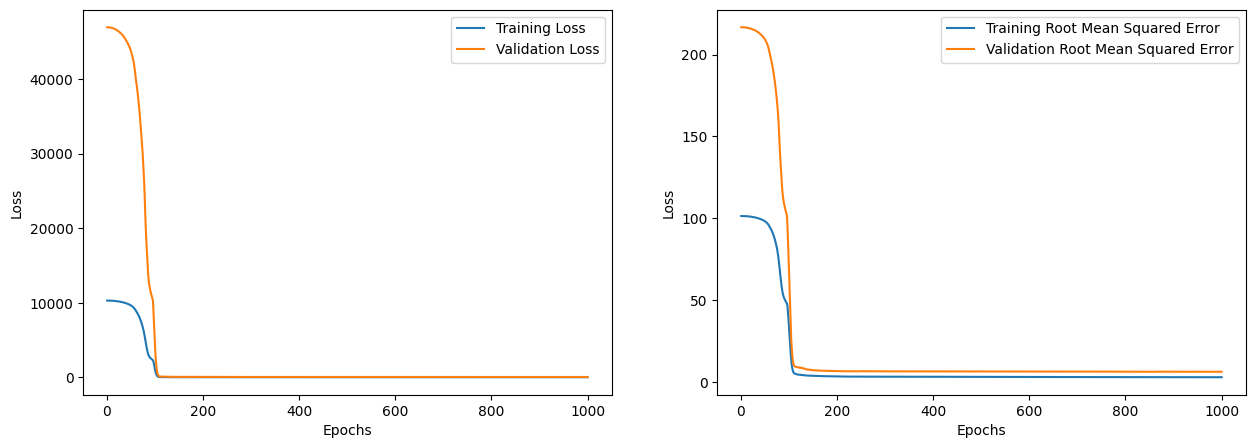

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Microsoft

In [57]:
MSFT_prediction = MSFT_Model.predict(MSFT_Test_X)

1/1 [==============================] - 0s 206ms/step


2024-12-08 10:01:50.032757: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


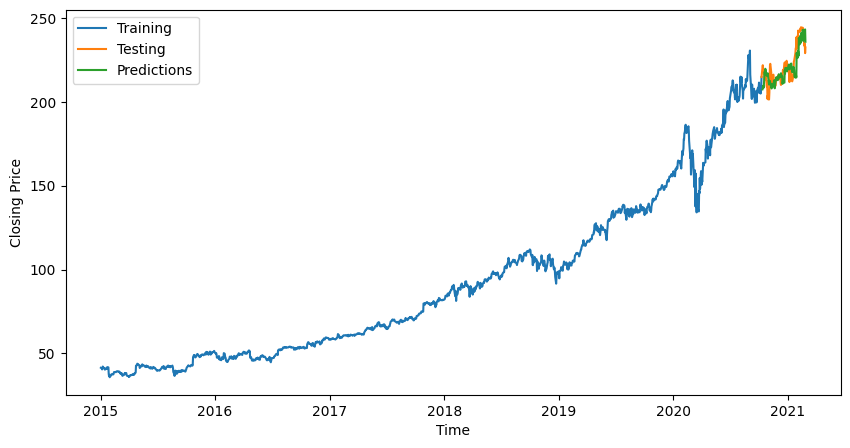

In [58]:
plt.figure(figsize=(10, 5))
plt.plot(MSFT['Date'][MSFT['Date'] < '2020-10-12'], MSFT['Adj. Close'][MSFT['Date'] < '2020-10-12'], label = 'Training')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-09'], MSFT['Adj. Close'][MSFT['Date'] >= '2020-10-09'], label = 'Testing')
plt.plot(MSFT['Date'][MSFT['Date'] >= '2020-10-12'], MSFT_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [59]:
rmse = math.sqrt(mean_squared_error(MSFT_Test_Y.reshape(-1, 5), MSFT_prediction))
mape = np.mean(np.abs(MSFT_prediction - MSFT_Test_Y.reshape(-1, 5))/np.abs(MSFT_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 6.356109291781042
MAPE: 0.022383293032935483


# Amazon

In [60]:
AMZN.head()

,Date,Open,High,Low,Close,Adj. Close,Volume
0,2015-01-02,312.58,314.75,306.96,308.52,308.52,2783200.0
1,2015-01-05,307.01,308.38,300.85,302.19,302.19,2774200.0
2,2015-01-06,302.24,303.00,292.38,295.29,295.29,3519000.0
3,2015-01-07,297.50,301.28,295.33,298.42,298.42,2640300.0
4,2015-01-08,300.32,303.14,296.11,300.46,300.46,3088400.0


In [61]:
AMZN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1549 entries, 0 to 1548
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        1549 non-null   object 
 1   Open        1549 non-null   float64
 2   High        1549 non-null   float64
 3   Low         1549 non-null   float64
 4   Close       1549 non-null   float64
 5   Adj. Close  1549 non-null   float64
 6   Volume      1549 non-null   float64
dtypes: float64(6), object(1)
memory usage: 84.8+ KB


In [62]:
# Change Dtype of Date column
AMZN["Date"] = pd.to_datetime(AMZN["Date"])

### Split the Data into Training and Test set
    Training Period: 2015-01-02 - 2020-10-30

    Testing Period:  2020-11-02 - 2021-02-26

In [63]:
AMZN_Date = '2020-11-01'
AMZN_Train_X, AMZN_Train_Y, AMZN_Test_X, AMZN_Test_Y = Dataset(AMZN, AMZN_Date)

### Model Fitting

In [64]:
AMZN_Model = Model()

In [65]:
# Change the keras optimiser to legacy Adam since running on Apple MacBook Silicon to avoid slowdown
AMZN_Model.compile(optimizer = tf.keras.optimizers.legacy.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

# Uncomment this code if using other CPUs apart from Apple Silicon and comment out the one above
#AMZN_Model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'mse', metrics = tf.keras.metrics.RootMeanSquaredError())

In [66]:
AMZN_hist = AMZN_Model.fit(AMZN_Train_X, AMZN_Train_Y, epochs = 200, validation_data = (AMZN_Test_X, AMZN_Test_Y), callbacks=[callback], verbose=0)

2024-12-08 10:01:50.940168: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-08 10:01:52.342204: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [67]:
history_dict = AMZN_hist.history

loss = history_dict["loss"]
root_mean_squared_error = history_dict["root_mean_squared_error"]
val_loss = history_dict["val_loss"]
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]

epochs = range(1, len(loss) + 1)

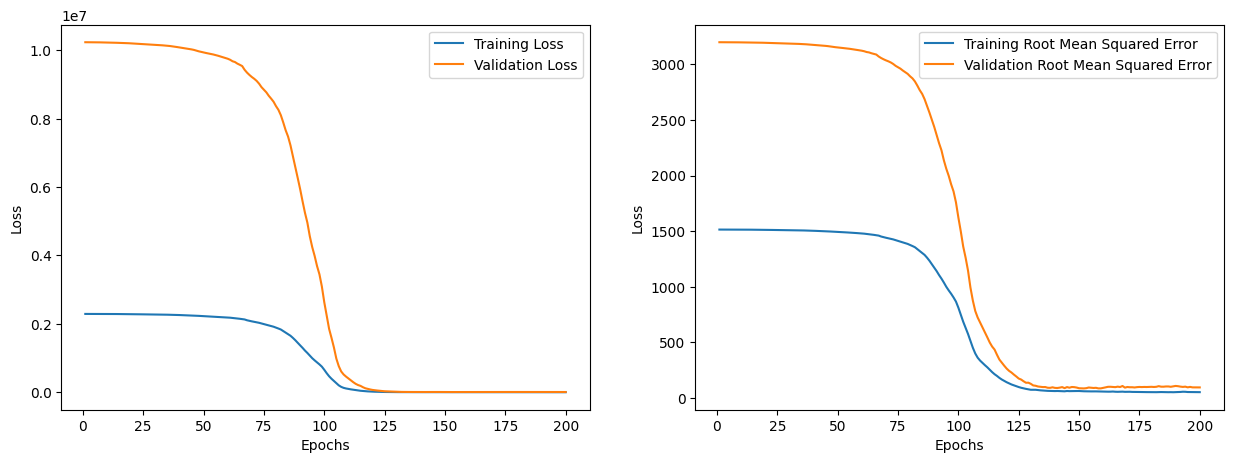

In [68]:
fig, (ax1, ax2) = plt.subplots(1, 2)

fig.set_figheight(5)
fig.set_figwidth(15)

ax1.plot(epochs, loss, label = "Training Loss")
ax1.plot(epochs, val_loss, label = "Validation Loss")
ax1.set(xlabel = "Epochs", ylabel = "Loss")
ax1.legend()

ax2.plot(epochs, root_mean_squared_error, label = "Training Root Mean Squared Error")
ax2.plot(epochs, val_root_mean_squared_error, label = "Validation Root Mean Squared Error")
ax2.set(xlabel = "Epochs", ylabel = "Loss")
ax2.legend()

plt.show()

### Predicting the closing stock price of Amazon

In [69]:
AMZN_prediction = AMZN_Model.predict(AMZN_Test_X)

1/1 [==============================] - 0s 179ms/step


2024-12-08 10:26:55.999883: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


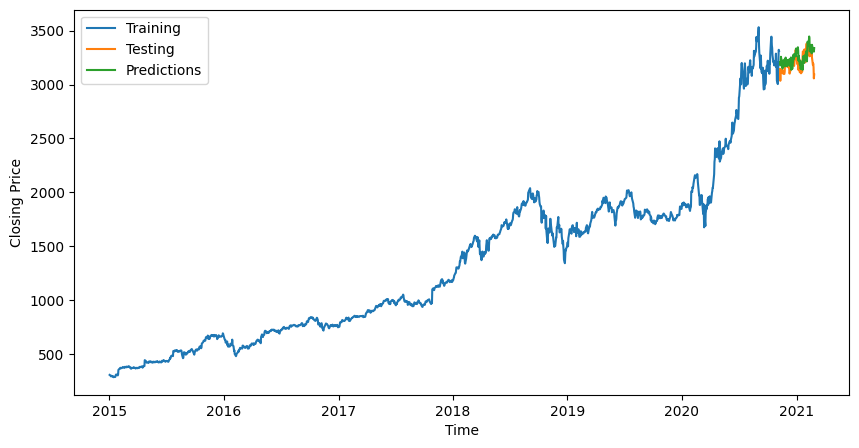

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(AMZN['Date'][AMZN['Date'] < '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] < '2020-11-07'], label = 'Training')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN['Adj. Close'][AMZN['Date'] >= '2020-11-07'], label = 'Testing')
plt.plot(AMZN['Date'][AMZN['Date'] >= '2020-11-07'], AMZN_prediction.reshape(-1), label = 'Predictions')
plt.xlabel('Time')
plt.ylabel('Closing Price')
plt.legend(loc = 'best')

In [71]:
rmse = math.sqrt(mean_squared_error(AMZN_Test_Y.reshape(-1, 5), AMZN_prediction))
mape = np.mean(np.abs(AMZN_prediction - AMZN_Test_Y.reshape(-1, 5))/np.abs(AMZN_Test_Y.reshape(-1, 5)))
print(f'RMSE: {rmse}')
print(f'MAPE: {mape}')

RMSE: 93.76039588989391
MAPE: 0.024378263855077364
